In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/iot_proj_ntu/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Donwload dataset from kaggle
! kaggle datasets download -d omkargurav/face-mask-dataset
! unzip face-mask-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/with_mask/with_mask_3297.jpg  
  inflating: data/with_mask/with_mask_3298.jpg  
  inflating: data/with_mask/with_mask_3299.jpg  
  inflating: data/with_mask/with_mask_33.jpg  
  inflating: data/with_mask/with_mask_330.jpg  
  inflating: data/with_mask/with_mask_3300.jpg  
  inflating: data/with_mask/with_mask_3301.jpg  
  inflating: data/with_mask/with_mask_3302.jpg  
  inflating: data/with_mask/with_mask_3303.jpg  
  inflating: data/with_mask/with_mask_3304.jpg  
  inflating: data/with_mask/with_mask_3305.jpg  
  inflating: data/with_mask/with_mask_3306.jpg  
  inflating: data/with_mask/with_mask_3307.jpg  
  inflating: data/with_mask/with_mask_3308.jpg  
  inflating: data/with_mask/with_mask_3309.jpg  
  inflating: data/with_mask/with_mask_331.jpg  
  inflating: data/with_mask/with_mask_3310.jpg  
  inflating: data/with_mask/with_mask_3311.jpg  
  inflating: data/with_mask/with_mask_3312.jpg  
  inflating: data/with

In [5]:
import numpy as np 
import pandas as pd
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
import torchvision
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
#transform the images to the default input shape 32x32
transform = transforms.Compose([transforms.Resize([32, 32]), transforms.ToTensor()])
data_set = datasets.ImageFolder(root = 'data', transform = transform)
data_set.class_to_idx = {'with_mask':1, 'without_mask':0}
n = len(data_set)
n_test = int( n * .2 )
n_train = n - n_test

In [7]:
# train, test split
train_set, test_set = data.random_split(data_set, (n_train, n_test))
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 8, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 8, shuffle = True)

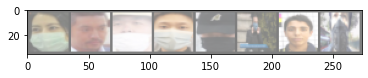

with_mask without_mask with_mask with_mask with_mask with_mask without_mask with_mask


In [8]:
# See sample data
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
classes = ('with_mask', 'without_mask')

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [9]:
# Neural net model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
def images_to_probs(net, images):
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.to('cpu').numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def evaluate(net, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)
            correct += (preds == labels).sum()
    return correct/total * 100

def train(net, loss_fn, opt, dataloader, epochs):
    num_steps = 0
    min_loss = 1e+10

    acc_list = []
    loss_list = []

    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        running_loss = []
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            num_steps += 1

            # FP
            outs = net(images)
            loss = loss_fn(outs, labels)

            # Logging the loss value
            running_loss.append(loss.item())

            # BP
            opt.zero_grad()
            loss.backward()
            opt.step()

        
        epoch_loss = sum(running_loss) / len(running_loss)
        acc = evaluate(net, dataloader)
        acc_list.append(acc)
        loss_list.append(epoch_loss)
        print("Accuracy: ",acc)
        print("loss: ",epoch_loss)
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            bestmodel = net.state_dict()
            
    return bestmodel, acc_list, loss_list

    print('Training finished!!!')
    
best_model, acc_list, loss_list = train(net, criterion, optimizer, train_loader, 10)
# load best model
net.load_state_dict(best_model)

# Specify a path
PATH = "face_detect_model.pt"

# Save
torch.save(net, PATH)
model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('model_scripted.pt')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Accuracy:  52.54012907496277
loss:  0.8618532371111017
Accuracy:  83.73324507694853
loss:  0.6122004794420073
Accuracy:  89.12791659771636
loss:  0.3416513026539217
Accuracy:  89.47542611285785
loss:  0.28047493576545207
Accuracy:  87.85371504219759
loss:  0.24958970920286244
Accuracy:  91.69286778090353
loss:  0.23477378247241693
Accuracy:  92.52027138838326
loss:  0.2279350068161471
Accuracy:  92.60301174913123
loss:  0.2160867052928855
Accuracy:  93.19874234651662
loss:  0.2019811035983915
Accuracy:  93.79447294390204
loss:  0.18636908655568574


In [11]:
# Save best model for inference
torch.save(best_model, 'model_state_dict.pt')

# Evaluated best model
model_acc = evaluate(net,train_loader)
print("Best model train accuracy: ", model_acc)

# Evaluated best model
model_acc = evaluate(net,test_loader)
print("Best model test accuracy: ", model_acc)

# Test loading saved model
model = torch.load(PATH)
model.eval()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Best model train accuracy:  93.79447294390204
Best model test accuracy:  92.25165562913908


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

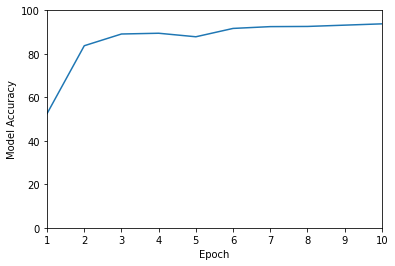

In [22]:
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,acc_list)
plt.axis([1, 10, 0, 100])

plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.show()

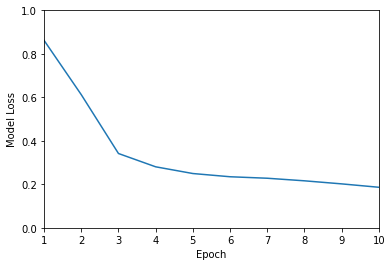

In [24]:
x = [1,2,3,4,5,6,7,8,9,10]
plt.plot(x,loss_list)
plt.axis([1, 10, 0, 1])

plt.ylabel('Model Loss')
plt.xlabel('Epoch')
plt.show()